# Step 5
Consider the case in which there is a single-user class C1. Assume that the curve related to the pricing problem is unknown while the curves related to the advertising problems are known. Further- more, consider the situation in which the curves related to pricing are non-stationary, being subject to seasonal phases (3 different
21
phases spread over the time horizon). Provide motivation for the phases. Apply the UCB1 algorithm and two non-stationary flavors of the UCB1 algorithm defined as follows. The first one is passive and exploits a sliding window, while the second one is active and exploits a change detection test. Provide a sensitivity analysis of the parameters employed in the algorithms, evaluating different values of the length of the sliding window in the first case and different values for the parameters of the change detection test in the second case. Report the plots with the average (over a sufficiently large num- ber of runs) value and standard deviation of the cumulative regret, cumulative reward, instantaneous regret, and instantaneous reward. Compare the results of the three algorithms used.

In [69]:
import numpy as np
import Environment5 as env
import utils.UCB_Opt5 as ucb_opt
import utils.UCB5 as ucb
import utils.UCB_SW as swucb
import utils.UCB_Cusum as cusumucb
import matplotlib.pyplot as plt

from tqdm import tqdm

In [70]:
T = 365
class_id = 1
n_experiments = 400

env5 = env.Environment5(class_id, T)

optimal_price = np.array([env5.get_optimal_price(t) for t in range(T)])

n_arms = env5.n_arms


window_size = int(2 * (T ** 0.5))
M = 25
eps = 0.01
h = 0.5 * np.log(T)
alpha = np.sqrt(5 * np.log(T) / T)

In [71]:
ucb_rewards_per_experiment = []
swucb_rewards_per_experiment = []
cusumucb_rewards_per_experiment = []

cumregret_ucb = []
cumregret_swucb = []
cumregret_cusumucb = []

cumreward_ucb = []
cumreward_swucb = []
cumreward_cusumucb = []

In [72]:
for e in tqdm(range(0, n_experiments)):
    # Create environment and learners
    ucb_optimizer = ucb_opt.UCB_BaseOptimizer_5(ucb.UCB5Learner, class_id, (n_arms,))
    swucb_optimizer = ucb_opt.UCB_BaseOptimizer_5(swucb.SWUCB, class_id, (n_arms, window_size))
    cusum_ucb_optimizer = ucb_opt.UCB_BaseOptimizer_5(cusumucb.CusumUCBLearner, class_id, (n_arms, M, eps, h, alpha))

    for t in range(0, T):
        # UCB
        pulled_arm_price, pulled_arm_bid = ucb_optimizer.pull_arm()
        reward = env5.round(pulled_arm_price, pulled_arm_bid, t)
        ucb_optimizer.update(pulled_arm_price, reward)

        # UCB Sliding Window
        pulled_arm_price, pulled_arm_bid = swucb_optimizer.pull_arm()
        reward = env5.round(pulled_arm_price, pulled_arm_bid, t)
        swucb_optimizer.update(pulled_arm_price, reward)

        # UCB Change Detection (CUSUM)
        pulled_arm_price, pulled_arm_bid = cusum_ucb_optimizer.pull_arm()
        reward = env5.round(pulled_arm_price, pulled_arm_bid, t)
        cusum_ucb_optimizer.update(pulled_arm_price, reward)

    # Store collected rewards
    ucb_rewards_per_experiment.append(ucb_optimizer.collected_rewards)
    swucb_rewards_per_experiment.append(swucb_optimizer.collected_rewards)
    cusumucb_rewards_per_experiment.append(cusum_ucb_optimizer.collected_rewards)

    cumregret_ucb.append(np.cumsum(optimal_price - ucb_rewards_per_experiment[e]))
    cumregret_swucb.append(np.cumsum(optimal_price - swucb_rewards_per_experiment[e]))
    cumregret_cusumucb.append(np.cumsum(optimal_price - cusumucb_rewards_per_experiment[e]))

    cumreward_ucb.append(np.cumsum(ucb_rewards_per_experiment[e]))
    cumreward_swucb.append(np.cumsum(swucb_rewards_per_experiment[e]))
    cumreward_cusumucb.append(np.cumsum(cusumucb_rewards_per_experiment[e]))

100%|██████████| 400/400 [00:53<00:00,  7.51it/s]


## Cumulative Regret

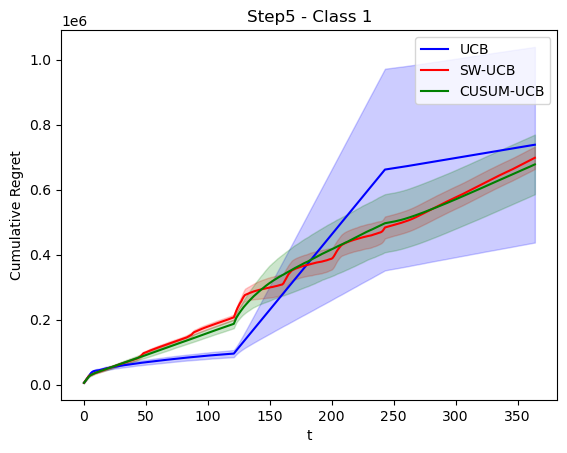

In [73]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Cumulative Regret")
plt.plot(np.mean(cumregret_ucb, axis=0), 'b')
plt.plot(np.mean(cumregret_swucb, axis=0), 'r')
plt.plot(np.mean(cumregret_cusumucb, axis=0), 'g')
plt.fill_between(range(T), np.mean(cumregret_ucb, axis=0) - np.std(cumregret_ucb, axis=0),
                 np.mean(cumregret_ucb, axis=0) + np.std(cumregret_ucb, axis=0), color="blue", alpha=0.2)
plt.fill_between(range(T), np.mean(cumregret_swucb, axis=0) - np.std(cumregret_swucb, axis=0),
                 np.mean(cumregret_swucb, axis=0) + np.std(cumregret_swucb, axis=0), color="red", alpha=0.2)
plt.fill_between(range(T), np.mean(cumregret_cusumucb, axis=0) - np.std(cumregret_cusumucb, axis=0),
                 np.mean(cumregret_cusumucb, axis=0) + np.std(cumregret_cusumucb, axis=0), color="green", alpha=0.2)
plt.legend(["UCB", "SW-UCB", "CUSUM-UCB"])
plt.show()

## Instantaneous Regret

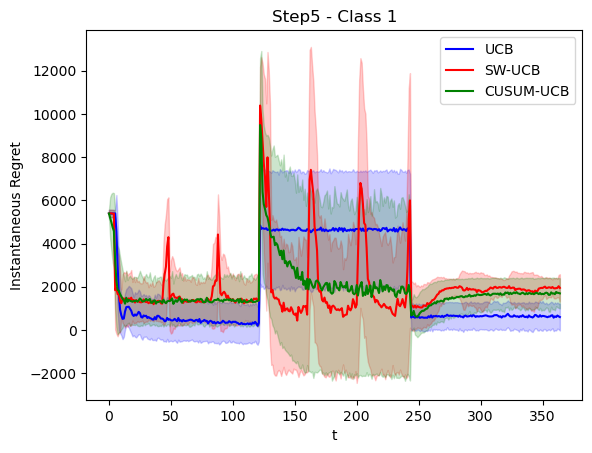

In [74]:
plt.figure(1)
plt.xlabel("t")
plt.ylabel("Instantaneous Regret")
plt.plot(np.mean(optimal_price - ucb_rewards_per_experiment, axis=0), 'b')
plt.plot(np.mean(optimal_price - swucb_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(optimal_price - cusumucb_rewards_per_experiment, axis=0), 'g')
plt.fill_between(range(T),
                 np.mean(optimal_price - ucb_rewards_per_experiment, axis=0) - np.std(optimal_price - ucb_rewards_per_experiment, axis=0),
                 np.mean(optimal_price - ucb_rewards_per_experiment, axis=0) + np.std(optimal_price - ucb_rewards_per_experiment, axis=0),
                 color="blue", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(optimal_price - swucb_rewards_per_experiment, axis=0) - np.std(optimal_price - swucb_rewards_per_experiment,
                                                                              axis=0),
                 np.mean(optimal_price - swucb_rewards_per_experiment, axis=0) + np.std(optimal_price - swucb_rewards_per_experiment,
                                                                              axis=0), color="red", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(optimal_price - cusumucb_rewards_per_experiment, axis=0) - np.std(optimal_price - cusumucb_rewards_per_experiment,
                                                                                 axis=0),
                 np.mean(optimal_price - cusumucb_rewards_per_experiment, axis=0) + np.std(optimal_price - cusumucb_rewards_per_experiment,
                                                                                 axis=0), color="green", alpha=0.2)
plt.legend(["UCB", "SW-UCB", "CUSUM-UCB"])
plt.show()

## Cumulative Reward

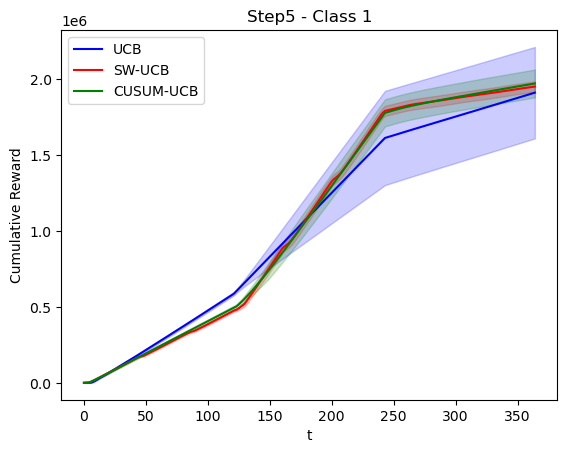

In [75]:
plt.figure(2)
plt.xlabel("t")
plt.ylabel("Cumulative Reward")
plt.plot(np.mean(cumreward_ucb, axis=0), 'b')
plt.plot(np.mean(cumreward_swucb, axis=0), 'r')
plt.plot(np.mean(cumreward_cusumucb, axis=0), 'g')
plt.fill_between(range(T), np.mean(cumreward_ucb, axis=0) - np.std(cumreward_ucb, axis=0),
                 np.mean(cumreward_ucb, axis=0) + np.std(cumreward_ucb, axis=0), color="blue", alpha=0.2)
plt.fill_between(range(T), np.mean(cumreward_swucb, axis=0) - np.std(cumreward_swucb, axis=0),
                 np.mean(cumreward_swucb, axis=0) + np.std(cumreward_swucb, axis=0), color="red", alpha=0.2)
plt.fill_between(range(T), np.mean(cumreward_cusumucb, axis=0) - np.std(cumreward_cusumucb, axis=0),
                 np.mean(cumreward_cusumucb, axis=0) + np.std(cumreward_cusumucb, axis=0), color="green", alpha=0.2)
plt.legend(["UCB", "SW-UCB", "CUSUM-UCB"])
plt.show()

## Instantaneous Reward

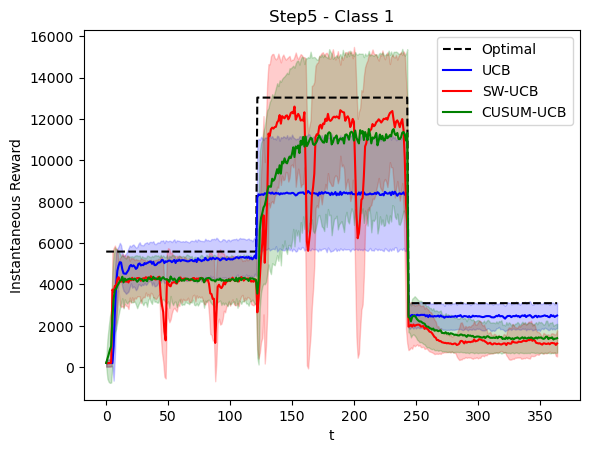

In [76]:
plt.figure(3)
plt.xlabel("t")
plt.ylabel("Instantaneous Reward")
plt.plot(optimal_price, 'k--')
plt.plot(np.mean(ucb_rewards_per_experiment, axis=0), 'b')
plt.plot(np.mean(swucb_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(cusumucb_rewards_per_experiment, axis=0), 'g')
plt.fill_between(range(T), np.mean(ucb_rewards_per_experiment, axis=0) - np.std(ucb_rewards_per_experiment, axis=0),
                 np.mean(ucb_rewards_per_experiment, axis=0) + np.std(ucb_rewards_per_experiment, axis=0), color="blue",
                 alpha=0.2)
plt.fill_between(range(T), np.mean(swucb_rewards_per_experiment, axis=0) - np.std(swucb_rewards_per_experiment, axis=0),
                 np.mean(swucb_rewards_per_experiment, axis=0) + np.std(swucb_rewards_per_experiment, axis=0),
                 color="red", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(cusumucb_rewards_per_experiment, axis=0) - np.std(cusumucb_rewards_per_experiment, axis=0),
                 np.mean(cusumucb_rewards_per_experiment, axis=0) + np.std(cusumucb_rewards_per_experiment, axis=0),
                 color="green", alpha=0.2)
plt.legend(["Optimal", "UCB", "SW-UCB", "CUSUM-UCB"])
plt.show()